# Backward-Compatible Representation Learning with DualPrompt

## Continual Learning and Feature Compatibility Analysis

This project investigates the backward compatibility of feature representations learned by a continual learning model (DualPrompt), following the evaluation principles introduced in *Towards Backward-Compatible Representation Learning*.

The goal is to verify whether features extracted from an updated model can be used as **queries** against a **gallery indexed with features from a previous model**, without re-extracting the gallery features.


## Environment Setup

This section reports the execution environment by checking:
- the PyTorch version
- CUDA availability
- the number of available GPUs

This information is provided to ensure reproducibility of the experiments.


In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Num GPUs:", torch.cuda.device_count())

PyTorch version: 2.9.0+cu128
CUDA available: True
Num GPUs: 1


## DualPrompt Codebase

For the experimental phase, a PyTorch-based implementation of DualPrompt was employed, preferred over the official release for its superior portability and compatibility with Google Colab. This codebase ensures parity of results and strictly adheres to the original design, while providing a more adaptable structure for testing and integration.


In [ ]:
!git clone https://github.com/JH-LEE-KR/dualprompt-pytorch.git
%cd dualprompt-pytorch

## Dependency Installation

The main dependencies required for training and evaluation are installed, including:
- PyTorch and torchvision
- timm for Vision Transformer models
- utility libraries for preprocessing and visualization


In [ ]:
!pip install --upgrade pip
!pip install torch torchvision timm pillow matplotlib

In [ ]:
!pip install timm==0.6.7

## Dataset: CIFAR-100

The DualPrompt model is trained on **CIFAR-100**, a standard benchmark for continual learning.

The dataset contains:
- 100 object classes
- RGB images of size 32×32
- standard train/test splits

The dataset is downloaded locally and used for training.


In [5]:
import os
from torchvision import datasets

data_path = "./data"
os.makedirs(data_path, exist_ok=True)
datasets.CIFAR100(root=data_path, download=True, train=True)
datasets.CIFAR100(root=data_path, download=True, train=False)
print(" CIFAR-100 saved in:", data_path)

100%|██████████| 169M/169M [00:18<00:00, 9.15MB/s]


 CIFAR-100 saved in: ./data


## Pre-trained Model Cache

A local directory is specified for caching pre-trained models used by `timm`.
This avoids repeated downloads and improves execution efficiency.


In [6]:
import os

os.environ['TORCH_HOME'] = './torch_cache'
os.makedirs(os.environ['TORCH_HOME'], exist_ok=True)
print("Pre-trained model saved in:", os.environ['TORCH_HOME'])

Pre-trained model saved in: ./torch_cache


## Continual Learning Training with DualPrompt

In this step, the model is trained using **DualPrompt** on CIFAR-100.

Key settings:
- Backbone: Vision Transformer (ViT-B/16)
- Method: DualPrompt
- Scenario: class-incremental continual learning
- Output: a trained model with dynamically selected prompts

The training follows the standard configuration provided in the official repository.


In [ ]:
!python -m torch.distributed.run \
    --nproc-per-node=1 \
    main.py cifar100_dualprompt \
    --model vit_base_patch16_224 \
    --batch-size 64 \
    --data-path ./data \
    --output_dir ./output


| distributed init (rank 0): env://
/usr/local/lib/python3.12/dist-packages/torch/distributed/distributed_c10d.py:4876: UserWarning: barrier(): using the device under current context. You can specify `device_id` in `init_process_group` to mute this warning.
  warnings.warn(  # warn only once
[rank0]:[W122 16:08:39.217019991 ProcessGroupNCCL.cpp:5068] Guessing device ID based on global rank. This can cause a hang if rank to GPU mapping is heterogeneous. You can specify device_id in init_process_group()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Creating original model: vit_base_patc

## Model Evaluation

After training, the model is evaluated in inference mode.
This step verifies that training has completed successfully and loads the saved model weights for subsequent experiments.


In [ ]:
!python -m torch.distributed.run \
    --nproc-per-node=1 \
    main.py cifar100_dualprompt \
    --eval \
    --model vit_base_patch16_224 \
    --data-path ./data \
    --output_dir ./output
# modify main.py adding weights_only=False at row 107

| distributed init (rank 0): env://
/usr/local/lib/python3.12/dist-packages/torch/distributed/distributed_c10d.py:4876: UserWarning: barrier(): using the device under current context. You can specify `device_id` in `init_process_group` to mute this warning.
  warnings.warn(  # warn only once
[rank0]:[W122 19:00:43.004228735 ProcessGroupNCCL.cpp:5068] Guessing device ID based on global rank. This can cause a hang if rank to GPU mapping is heterogeneous. You can specify device_id in init_process_group()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Creating original model: vit_base_patc

## Dataset Structure and Overlap Analysis

Before proceeding with feature extraction and backward-compatible retrieval experiments, it is necessary to analyze the structure of the datasets involved and verify the absence of unintended overlaps.

Three datasets are used at different stages of the pipeline:

- **ImageNet**: used to pre-train the Vision Transformer (ViT-B/16) backbone.
- **CIFAR-100**: used to train the DualPrompt model in a continual learning setting.
- **CIFAR-10**: used exclusively for backward compatibility and retrieval experiments (gallery–query matching).

### ImageNet vs CIFAR Datasets

ImageNet and CIFAR datasets differ significantly in both image resolution and data curation process:

- ImageNet contains high-resolution natural images collected from the web and manually curated.
- CIFAR-10 and CIFAR-100 consist of 32×32 images derived from a different collection pipeline.

There is no instance-level overlap between ImageNet and CIFAR datasets. While some semantic categories may share similar names (e.g., *dog*, *car*), the actual images are distinct. Therefore, ImageNet pre-training does not introduce data leakage into CIFAR-based experiments.

### CIFAR-100 vs CIFAR-10

CIFAR-10 and CIFAR-100 are constructed from the same original image pool but are split into **disjoint label sets**:

- CIFAR-10 contains 10 coarse-grained classes.
- CIFAR-100 contains 100 fine-grained classes.

Each image appears in **only one** of the two datasets, and no image is shared between CIFAR-10 and CIFAR-100. Consequently:

- Training DualPrompt on CIFAR-100 does not expose the model to any images from CIFAR-10.
- CIFAR-10 can be safely used as an independent benchmark for evaluating backward compatibility.

### Implications for Backward-Compatible Evaluation

This dataset separation ensures that:

- Feature representations extracted from the DualPrompt model are evaluated on **unseen data**.
- Gallery–query matching on CIFAR-10 measures representation consistency rather than memorization.
- Backward compatibility is tested under a realistic deployment scenario, where a new model must interoperate with previously indexed features from a different data distribution.

This setup aligns with the assumptions of backward-compatible representation learning, where old embeddings and new embeddings coexist without requiring reprocessing of the original gallery.


In [ ]:
import torchvision.transforms as transforms

# ----------------------------
# Load CIFAR-10 and CIFAR-100
# ----------------------------

transform = transforms.ToTensor()

cifar10_train = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

cifar100_train = datasets.CIFAR100(root=data_path, train=True, download=False, transform=transform)
cifar100_test = datasets.CIFAR100(root=data_path, train=False, download=False, transform=transform)

100%|██████████| 170M/170M [00:02<00:00, 76.0MB/s]


In [ ]:
# ----------------------------
# Dataset statistics
# ----------------------------

print("CIFAR-10: ")
print(" Train samples:", len(cifar10_train))
print(" Test samples:", len(cifar10_test))
print(" Classes:", cifar10_train.classes)

print("\nCIFAR-100: ")
print(" Train samples:", len(cifar100_train))
print(" Test samples:", len(cifar100_test))
print(" Classes:", cifar100_train.classes)

CIFAR-10: 
 Train samples: 50000
 Test samples: 10000
 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

CIFAR-100: 
 Train samples: 50000
 Test samples: 10000
 Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper

In [ ]:
# ----------------------------
# Helper: compute image hash
# ----------------------------

import hashlib
import numpy as np

def image_hash(img_tensor):
    """
    Compute a hash for an image tensor.
    Tensor shape: [C, H, W]
    """
    img_bytes = (img_tensor.numpy() * 255).astype(np.uint8).tobytes()
    return hashlib.md5(img_bytes).hexdigest()

In [ ]:
num_samples = 5000  # subset size to keep computation reasonable

cifar10_hashes = set(
    image_hash(cifar10_train[i][0]) for i in range(num_samples)
)

overlap_count = 0
for i in range(num_samples):
    h = image_hash(cifar100_train[i][0])
    if h in cifar10_hashes:
        overlap_count += 1

print(f"Checked {num_samples} images from each dataset.")
print(f"Number of overlapping images found: {overlap_count}")

if overlap_count == 0:
    print("No image-level overlap detected between CIFAR-10 and CIFAR-100.")
else:
    print("Potential overlap detected (unexpected).")

Checked 5000 images from each dataset.
Number of overlapping images found: 0
No image-level overlap detected between CIFAR-10 and CIFAR-100.


## Feature Extractor Construction from DualPrompt Checkpoints

To evaluate representation stability and backward compatibility, the classification head is removed and only the feature extractor is retained. The analysis focuses on the output of the last layer before the classification head, which represents the learned embedding used for retrieval.

### Checkpoint Selection

DualPrompt training produces a sequence of checkpoints corresponding to different tasks. Each checkpoint represents a model state after learning a new subset of classes. In this experiment:

- One feature extractor is built from each checkpoint.
- A total of 10 models are considered, corresponding to the 10 incremental tasks.
- All models share the same Vision Transformer backbone architecture.

This setup allows tracking how the learned representation evolves across tasks and enables direct comparison between embeddings extracted at different stages of continual learning.

### Purpose for Backward Compatibility Evaluation

Using feature-only models enables:

- Direct comparison between embeddings from different checkpoints.
- Simulation of a real-world deployment scenario where older gallery features coexist with newer query features.
- Evaluation of whether queries generated by a newer model can successfully retrieve gallery items indexed with older embeddings.

The extracted embeddings serve as the basis for retrieval experiments on CIFAR-10, using backward compatibility criteria inspired by the BCT framework.


In [7]:
# Download DualPrompt checkpoints from Google Drive
import gdown

output_dir = './output/checkpoint'
os.makedirs(output_dir, exist_ok=True)

folder_id = 'https://drive.google.com/drive/folders/1PdhU4Ko7iRqoPjZzsAG_eZ4S8TRJSrM0?usp=sharing'
gdown.download_folder(url=folder_id, output=output_dir, quiet=True)
print("Checkpoints downloaded to:", output_dir)

Checkpoints downloaded to: ./output/checkpoint


In [8]:
from timm.models import create_model
import models


# -----------------------------
# Configuration
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_TASKS = 10
CHECKPOINT_DIR = "./output/checkpoint"

MODEL_NAME = "vit_base_patch16_224"
NUM_CLASSES = 100   # CIFAR-100
PROMPT_CONFIG = dict(
    prompt_length=5,
    embedding_key="cls",
    prompt_init="uniform",
    prompt_pool=True,
    prompt_key=True,
    pool_size=10,
    top_k=1,
    batchwise_prompt=True,
    head_type="token",
    use_prompt_mask=True,
    use_g_prompt=True,
    g_prompt_length=5,
    g_prompt_layer_idx=[0, 1],
    use_prefix_tune_for_g_prompt=True,
    use_e_prompt=True,
    e_prompt_layer_idx=[2, 3, 4],
    use_prefix_tune_for_e_prompt=True,
    same_key_value=False,
)

# -----------------------------
# Load DualPrompt Models
# -----------------------------
def load_dualprompt_models(remove_head=True):
    models = []

    for task_id in range(NUM_TASKS):

        # Create model (same as main.py)
        model = create_model(
            MODEL_NAME,
            pretrained=False,
            num_classes=NUM_CLASSES,
            drop_rate=0.0,
            drop_path_rate=0.0,
            **PROMPT_CONFIG
        )

        checkpoint_path = os.path.join(
            CHECKPOINT_DIR,
            f"task{task_id + 1}_checkpoint.pth"
        )

        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint["model"], strict=True)

        # Remove classification head → feature extractor
        if remove_head:
          model.head = torch.nn.Identity()

        model.to(device)
        model.eval()

        models.append(model)

    print("All DualPrompt models loaded successfully.")
    return models

In [ ]:
# Load models without classification head
dualprompt_models = load_dualprompt_models()

In [9]:
# Load models with classification head
dualprompt_models_with_head = load_dualprompt_models(remove_head=False)

All DualPrompt models loaded successfully.


In [57]:
model_0 = dualprompt_models_with_head[0]

total_params = 0
prompt_params = 0
head_params = 0
backbone_params = 0

for name, param in model_0.named_parameters():
    num_params = param.numel()
    total_params += num_params

    if 'prompt' in name:
        prompt_params += num_params
        print(f"✓ PROMPT: {name:50s} {num_params:>12,}")
    elif 'head' in name:
        head_params += num_params
        print(f"✓ HEAD:   {name:50s} {num_params:>12,}")
    else:
        backbone_params += num_params

print(f"\n{'='*60}")
print(f"Total parameters:        {total_params:>15,}")
print(f"Prompt parameters:       {prompt_params:>15,} ({100 * prompt_params / total_params:.2f}%)")
print(f"Head parameters:         {head_params:>15,} ({100 * head_params / total_params:.2f}%)")
print(f"Backbone parameters:     {backbone_params:>15,} ({100 * backbone_params / total_params:.2f}%)")
print(f"{'='*60}")
print(f"\nTypically trainable parameters in DualPrompt:")
print(f"  Prompt + Head:         {prompt_params + head_params:>15,} ({100 * (prompt_params + head_params) / total_params:.2f}%)")

✓ PROMPT: g_prompt                                                 15,360
✓ PROMPT: e_prompt.prompt                                         230,400
✓ PROMPT: e_prompt.prompt_key                                       7,680
✓ HEAD:   head.weight                                              76,800
✓ HEAD:   head.bias                                                   100

Total parameters:             86,128,996
Prompt parameters:               253,440 (0.29%)
Head parameters:                  76,900 (0.09%)
Backbone parameters:          85,798,656 (99.62%)

Typically trainable parameters in DualPrompt:
  Prompt + Head:                 330,340 (0.38%)


In [69]:
import torchvision.transforms as transforms


# Load CIFAR-100 test set
transform = transforms.Compose([
    transforms.Resize(224),  # ViT requires 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                        std=[0.2675, 0.2565, 0.2761])
])

cifar100_test = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Organize dataset by label
def organize_by_label(dataset):
    """Organize the dataset into a dictionary {label: [indices]}"""
    label_to_indices = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)
    return label_to_indices

label_to_indices = organize_by_label(cifar100_test)

print(f"Total test samples: {len(cifar100_test)}")
print(f"Number of classes: {len(label_to_indices)}")
print(f"Samples per class: {[len(indices) for label, indices in sorted(label_to_indices.items())[:5]]}...")

# Function to test on a specific label
def test_on_label(model, dataset, label, num_samples=5, device='cuda'):
    """
    Test the model on samples from a specific label

    Args:
        model: the model to test
        dataset: the CIFAR-100 dataset
        label: the label to test (0-99)
        num_samples: how many samples to test for that label
        device: 'cuda' or 'cpu'
    """
    model.eval()
    model = model.to(device)

    # Get indices for this label
    if label not in label_to_indices:
        print(f"Label {label} not found in dataset!")
        return

    indices = label_to_indices[label][:num_samples]

    print(f"\n{'='*80}")
    print(f"Testing on Label {label} - {cifar100_test.classes[label]}")
    print(f"{'='*80}")

    results = []

    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]

        # Forward pass
        with torch.no_grad():
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)

            if isinstance(output, dict):
                logits = output['logits']
            else:
                logits = output

            # Prediction
            probabilities = torch.softmax(logits, dim=-1)
            top5_probs, top5_indices = torch.topk(probabilities, k=5, dim=-1)

            predicted_label = top5_indices[0, 0].item()
            predicted_prob = top5_probs[0, 0].item()

            # Result
            is_correct = predicted_label == true_label
            results.append(is_correct)

            print(f"\nSample {i+1}/{len(indices)} (Index: {idx})")
            print(f"  True label:      {true_label} ({cifar100_test.classes[true_label]})")
            print(f"  Predicted label: {predicted_label} ({cifar100_test.classes[predicted_label]})")
            print(f"  Confidence:      {predicted_prob:.4f}")
            print(f"  Status:          {'✓ CORRECT' if is_correct else '✗ WRONG'}")

            # Top-5 predictions
            print(f"  Top-5 predictions:")
            for j in range(5):
                pred_idx = top5_indices[0, j].item()
                pred_prob = top5_probs[0, j].item()
                marker = "→" if pred_idx == true_label else " "
                print(f"    {marker} {pred_idx:2d} ({cifar100_test.classes[pred_idx]:20s}): {pred_prob:.4f}")

    # Summary
    accuracy = sum(results) / len(results) * 100
    print(f"\n{'='*80}")
    print(f"Accuracy on label {label}: {accuracy:.2f}% ({sum(results)}/{len(results)})")
    print(f"{'='*80}\n")

    return results

# Function to visualize predictions
def visualize_predictions(model, dataset, label, num_samples=5, device='cuda'):
    """
    Visualize images and predictions for a specific label
    """
    model.eval()
    model = model.to(device)

    if label not in label_to_indices:
        print(f"Label {label} not found!")
        return

    indices = label_to_indices[label][:num_samples]

    # Invert normalization for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.5071/0.2675, -0.4867/0.2565, -0.4408/0.2761],
        std=[1/0.2675, 1/0.2565, 1/0.2761]
    )

    fig, axes = plt.subplots(1, num_samples, figsize=(3*num_samples, 4))
    if num_samples == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]

        # Prediction
        with torch.no_grad():
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)

            if isinstance(output, dict):
                logits = output['logits']
            else:
                logits = output

            probabilities = torch.softmax(logits, dim=-1)
            predicted_label = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities[0, predicted_label].item()

        # Visualize
        img_display = inv_normalize(image).cpu().numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].axis('off')

        color = 'green' if predicted_label == true_label else 'red'
        title = f"True: {cifar100_test.classes[true_label]}\n"
        title += f"Pred: {cifar100_test.classes[predicted_label]}\n"
        title += f"Conf: {confidence:.3f}"
        axes[i].set_title(title, fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

# USAGE EXAMPLES

# Test on label 0
test_on_label(dualprompt_models_with_head[0], cifar100_test, label=9, num_samples=5, device='cuda')

Total test samples: 10000
Number of classes: 100
Samples per class: [100, 100, 100, 100, 100]...

Testing on Label 9 - bottle

Sample 1/5 (Index: 52)
  True label:      9 (bottle)
  Predicted label: 9 (bottle)
  Confidence:      0.9856
  Status:          ✓ CORRECT
  Top-5 predictions:
    →  9 (bottle              ): 0.9856
       7 (beetle              ): 0.0002
      10 (bowl                ): 0.0002
      27 (crocodile           ): 0.0002
      46 (man                 ): 0.0002

Sample 2/5 (Index: 114)
  True label:      9 (bottle)
  Predicted label: 9 (bottle)
  Confidence:      0.9801
  Status:          ✓ CORRECT
  Top-5 predictions:
    →  9 (bottle              ): 0.9801
       5 (bed                 ): 0.0003
      94 (wardrobe            ): 0.0003
      38 (kangaroo            ): 0.0003
      58 (pickup_truck        ): 0.0003

Sample 3/5 (Index: 170)
  True label:      9 (bottle)
  Predicted label: 9 (bottle)
  Confidence:      0.9404
  Status:          ✓ CORRECT
  Top-5 predi

[True, True, True, True, True]

In [56]:
# print model
print(dualprompt_models_with_head[0])

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (e_prompt): EPrompt()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): PreT_Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inpla

## Gallery–Query Protocol for Backward Compatibility

Backward compatibility is evaluated under an asymmetric retrieval setting, where **gallery features are fixed in the past**, while **query features are generated by a newer model**. No re-indexing of the gallery is ever performed.

### Gallery

- Contains features that have already been extracted.
- The gallery is **never re-indexed**.
- Features are extracted using an **older model**:

$$
\phi_{\text{old}}
$$

Formally, given a gallery image set $I_G$, gallery features are defined as:

$$
F_G = \phi_{\text{old}}(I_G)
$$

### Query

- Contains images arriving **after** the model update.
- Features are extracted using a **newer model**:

$$
\phi_{\text{new}}
$$

Given a query image set $I_Q$, query features are defined as:

$$
F_Q = \phi_{\text{new}}(I_Q)
$$

---

### Core Compatibility Criterion

Backward compatibility is satisfied if retrieval performance using **new query features against old gallery features** is **not worse than before**.

$$
\phi_{\text{new}}(x_q)
\;\; \text{vs} \;\;
\phi_{\text{old}}(x_g)
$$

If this comparison performs better (or at least not worse) than previous configurations, the representation is considered backward compatible.

> **Key principle:**
> The gallery always lives in the *past*, the query always lives in the *present*.


---

### Gallery and Query Construction

- **CIFAR-100** is used *only* for training DualPrompt.
- **CIFAR-10 test set** is used for both gallery and query.
- The *same images* appear in both sets.
- **Crucially:** features are extracted using *different models*.

| Role    | Images        | Feature extractor   |
|--------|---------------|---------------------|
| Gallery | CIFAR-10 test | $\phi_{\text{old}}$ |
| Query   | CIFAR-10 test | $\phi_{\text{new}}$ |

Thus, for two images $ x_g $ and $x_q$ :

$$
\phi_{\text{new}}(x_q)
\;\; \text{vs} \;\;
\phi_{\text{old}}(x_g)
$$

The task is to verify whether the two images belong to the **same CIFAR-10 class**.

### Open-Set Property

CIFAR-10 acts as an **open-set evaluation dataset**:

- Its classes **never appear** during training on CIFAR-100.
- Compatibility evaluation therefore measures *pure representational alignment*, not memorization or class overlap.



In [ ]:
# Prepare CIFAR-10 with correct preprocessing for ViT
from torch.utils.data import DataLoader
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
cifar10_test = datasets.CIFAR10(root=data_path, train=False, download=False, transform=vit_transform)

In [ ]:
# For each class use only 10% of the test set
import random
def reduce_cifar10_testset(dataset, reduction_factor=0.1):
    class_indices = {i: [] for i in range(10)}
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    reduced_indices = []
    for indices in class_indices.values():
        reduced_count = max(1, int(len(indices) * reduction_factor))
        reduced_indices.extend(random.sample(indices, reduced_count))
    reduced_dataset = torch.utils.data.Subset(dataset, reduced_indices)
    return reduced_dataset

In [ ]:
cifar10_test = reduce_cifar10_testset(cifar10_test, reduction_factor=0.1)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)
print("CIFAR-10 test set size after reduction:", len(cifar10_test))

CIFAR-10 test set size after reduction: 1000


In [ ]:
from tqdm import tqdm

feature_root = "./features_cifar10"
os.makedirs(feature_root, exist_ok=True)

def extract_features_to_disk(model, dataloader, device, task_id):
    """
    Extract CIFAR-10 features using a given model and save them batch-wise to disk.
    """
    model.eval()

    task_dir = os.path.join(feature_root, f"task_{task_id + 1}")
    os.makedirs(task_dir, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
            tqdm(dataloader, desc=f"Extracting features (task {task_id + 1})")
        ):
            images = images.to(device)

            outputs = model(images)
            feats = outputs["x"] if isinstance(outputs, dict) else outputs

            torch.save(
                {
                    "features": feats.cpu(),   # [B, D]
                    "labels": labels.cpu()     # [B]
                },
                os.path.join(task_dir, f"batch_{batch_idx:04d}.pt")
            )

    print(f"Features for task {task_id + 1} saved to {task_dir}")

In [ ]:
for task_id, model in enumerate(dualprompt_models):
    print(f"\nExtracting CIFAR-10 features using model from task {task_id + 1}")
    extract_features_to_disk(
        model=model,
        dataloader=cifar10_test_loader,
        device=device,
        task_id=task_id
    )

print("Feature extraction completed for all models.")


Extracting CIFAR-10 features using model from task 1


Extracting features (task 1): 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


Features for task 1 saved to ./features_cifar10/task_1

Extracting CIFAR-10 features using model from task 2


Extracting features (task 2): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


Features for task 2 saved to ./features_cifar10/task_2

Extracting CIFAR-10 features using model from task 3


Extracting features (task 3): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Features for task 3 saved to ./features_cifar10/task_3

Extracting CIFAR-10 features using model from task 4


Extracting features (task 4): 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


Features for task 4 saved to ./features_cifar10/task_4

Extracting CIFAR-10 features using model from task 5


Extracting features (task 5): 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


Features for task 5 saved to ./features_cifar10/task_5

Extracting CIFAR-10 features using model from task 6


Extracting features (task 6): 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


Features for task 6 saved to ./features_cifar10/task_6

Extracting CIFAR-10 features using model from task 7


Extracting features (task 7): 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Features for task 7 saved to ./features_cifar10/task_7

Extracting CIFAR-10 features using model from task 8


Extracting features (task 8): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


Features for task 8 saved to ./features_cifar10/task_8

Extracting CIFAR-10 features using model from task 9


Extracting features (task 9): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


Features for task 9 saved to ./features_cifar10/task_9

Extracting CIFAR-10 features using model from task 10


Extracting features (task 10): 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]

Features for task 10 saved to ./features_cifar10/task_10
Feature extraction completed for all models.


## Multi-step Backward Compatibility Evaluation

The backward compatibility evaluation is extended to multiple model upgrade steps, following the framework outlined in *Towards Backward-Compatible Representation Learning* and *CoReS: Compatible Representations via Stationarity*.

### Multi-model Empirical Compatibility Criterion

Let
- $\{\phi_1, \phi_2, \ldots, \phi_T\}$ be a sequence of representation models obtained through $ T $ upgrade steps,
- $ \phi_{t_0} $ be a newer model and $ \phi_t $ an older model, with $ t_0 > t $,
- $ M(\cdot) $ be an evaluation metric.

The multi-model empirical compatibility criterion is defined as:

$$
M(Q_{\phi_{t_0}}, G_{\phi_t}) > M(Q_{\phi_t}, G_{\phi_t}), \quad \forall \; t_0 > t
$$

where:
- $ Q_{\phi_{t_0}} $ denotes queries encoded using the newer model,
- $ G_{\phi_t} $ denotes gallery features encoded using the older model.

This criterion states that a newer model is backward compatible with an older one if its cross-test
performance exceeds the self-test performance of the older model.

---

### Compatibility Matrix

To evaluate compatibility across all upgrade steps, a Compatibility Matrix $ \mathbf{C} \in \mathbb{R}^{T \times T} $
is defined as:

$$
\mathbf{C} =
\begin{pmatrix}
M(Q_{\phi_1}, G_{\phi_1}) & 0 & \cdots & 0 \\
M(Q_{\phi_2}, G_{\phi_1}) & M(Q_{\phi_2}, G_{\phi_2}) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
M(Q_{\phi_T}, G_{\phi_1}) & M(Q_{\phi_T}, G_{\phi_2}) & \cdots & M(Q_{\phi_T}, G_{\phi_T})
\end{pmatrix}
$$

Diagonal entries correspond to self-tests, while off-diagonal entries $( i > j )$ represent cross-tests
between newer queries and older galleries.


### Average Multi-model Compatibility (AC)

The Average Multi-model Compatibility (AC) summarizes global backward compatibility:

$$
\text{AC} = \frac{2}{T(T-1)} \sum_{i=2}^{T} \sum_{j=1}^{i-1}
\mathbf{1} \left( C_{ij} > C_{jj} \right)
$$

where $ \mathbf{1}(\cdot) $ is the indicator function.

AC measures how often backward compatibility is satisfied across all model pairs.


### Average Multi-model Accuracy (AM)

Overall performance is summarized using the Average Multi-model Accuracy (AM):

$$
\text{AM} = \frac{2}{T(T+1)} \sum_{i=1}^{T} \sum_{j=1}^{i} C_{ij}
$$

AM represents the average accuracy over all valid self-tests and cross-tests.

---

### Application to DualPrompt-based Experiments

In this project:
- each upgrade step corresponds to a DualPrompt checkpoint trained on CIFAR-100,
- CIFAR-10 is used as an open-set evaluation dataset,
- gallery features are always extracted using older models,
- query features are extracted using newer models.

This setup enables a principled evaluation of backward compatibility across multiple continual learning stages.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# load one batch at a time to save memory
def load_feature_batch(task_id, batch_idx):
    task_dir = os.path.join(feature_root, f"task_{task_id + 1}")
    batch_file = os.path.join(task_dir, f"batch_{batch_idx:04d}.pt")
    data = torch.load(batch_file)
    return data["features"], data["labels"]

In [ ]:
# Get number of batches
sample_task_dir = os.path.join(feature_root, "task_1")
num_batches = len([f for f in os.listdir(sample_task_dir) if f.endswith('.pt')])
print("Number of batches:", num_batches)

Number of batches: 16


In [ ]:
import torch.nn.functional as F
import numpy as np

K = 5
compatibility_matrix = np.zeros((NUM_TASKS, NUM_TASKS))

for query_task in range(NUM_TASKS):
    for gallery_task in range(query_task + 1):   # triangolare inferiore

        # ========= LOAD GALLERY =========
        gallery_feats = []
        gallery_labels = []

        for batch_idx in range(num_batches):
            feats, labels = load_feature_batch(gallery_task, batch_idx)
            feats = F.normalize(feats.mean(dim=1), dim=1)
            gallery_feats.append(feats)
            gallery_labels.append(labels)

        gallery_feats = torch.cat(gallery_feats, dim=0)      # [Ng, D]
        gallery_labels = torch.cat(gallery_labels, dim=0)    # [Ng]

        # ========= LOAD QUERY =========
        query_feats = []
        query_labels = []

        for batch_idx in range(num_batches):
            feats, labels = load_feature_batch(query_task, batch_idx)
            feats = F.normalize(feats.mean(dim=1), dim=1)
            query_feats.append(feats)
            query_labels.append(labels)

        query_feats = torch.cat(query_feats, dim=0)          # [Nq, D]
        query_labels = torch.cat(query_labels, dim=0)        # [Nq]

        # ========= COSINE SIMILARITY =========
        sims = query_feats @ gallery_feats.T                 # [Nq, Ng]

        # ========= EXCLUDE SELF-MATCH =========
        '''if query_task == gallery_task:
            assert query_feats.size(0) == gallery_feats.size(0)
            idx = torch.arange(query_feats.size(0))
            sims[idx, idx] = -float("inf")'''

        # ========= k-NN =========
        topk_idx = sims.topk(K, dim=1).indices               # [Nq, K]
        topk_labels = gallery_labels[topk_idx]               # [Nq, K]

        preds, _ = torch.mode(topk_labels, dim=1)

        acc = (preds == query_labels).float().mean().item()
        compatibility_matrix[query_task, gallery_task] = acc

        print(
            f"Query {query_task+1} vs Gallery {gallery_task+1}: "
            f"kNN Acc = {acc:.4f}"
        )

Query 1 vs Gallery 1: kNN Acc = 0.9240
Query 2 vs Gallery 1: kNN Acc = 0.9280
Query 2 vs Gallery 2: kNN Acc = 0.9310
Query 3 vs Gallery 1: kNN Acc = 0.9230
Query 3 vs Gallery 2: kNN Acc = 0.9300
Query 3 vs Gallery 3: kNN Acc = 0.9300
Query 4 vs Gallery 1: kNN Acc = 0.9210
Query 4 vs Gallery 2: kNN Acc = 0.9260
Query 4 vs Gallery 3: kNN Acc = 0.9240
Query 4 vs Gallery 4: kNN Acc = 0.9250
Query 5 vs Gallery 1: kNN Acc = 0.9210
Query 5 vs Gallery 2: kNN Acc = 0.9240
Query 5 vs Gallery 3: kNN Acc = 0.9220
Query 5 vs Gallery 4: kNN Acc = 0.9200
Query 5 vs Gallery 5: kNN Acc = 0.9200
Query 6 vs Gallery 1: kNN Acc = 0.9210
Query 6 vs Gallery 2: kNN Acc = 0.9250
Query 6 vs Gallery 3: kNN Acc = 0.9220
Query 6 vs Gallery 4: kNN Acc = 0.9240
Query 6 vs Gallery 5: kNN Acc = 0.9190
Query 6 vs Gallery 6: kNN Acc = 0.9210
Query 7 vs Gallery 1: kNN Acc = 0.9180
Query 7 vs Gallery 2: kNN Acc = 0.9200
Query 7 vs Gallery 3: kNN Acc = 0.9200
Query 7 vs Gallery 4: kNN Acc = 0.9240
Query 7 vs Gallery 5: kNN

In [ ]:
print("\nAccuracy Matrix:")
import pandas as pd
df_acc = pd.DataFrame(compatibility_matrix, columns=[f"G{j+1}" for j in range(NUM_TASKS)],
                      index=[f"Q{i+1}" for i in range(NUM_TASKS)])
print(df_acc)


Accuracy Matrix:
        G1     G2     G3     G4     G5     G6     G7     G8     G9    G10
Q1   0.924  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
Q2   0.928  0.931  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
Q3   0.923  0.930  0.930  0.000  0.000  0.000  0.000  0.000  0.000  0.000
Q4   0.921  0.926  0.924  0.925  0.000  0.000  0.000  0.000  0.000  0.000
Q5   0.921  0.924  0.922  0.920  0.920  0.000  0.000  0.000  0.000  0.000
Q6   0.921  0.925  0.922  0.924  0.919  0.921  0.000  0.000  0.000  0.000
Q7   0.918  0.920  0.920  0.924  0.922  0.916  0.916  0.000  0.000  0.000
Q8   0.920  0.922  0.923  0.925  0.928  0.922  0.922  0.919  0.000  0.000
Q9   0.921  0.920  0.918  0.921  0.922  0.915  0.916  0.916  0.917  0.000
Q10  0.938  0.944  0.938  0.941  0.938  0.936  0.941  0.940  0.942  0.947


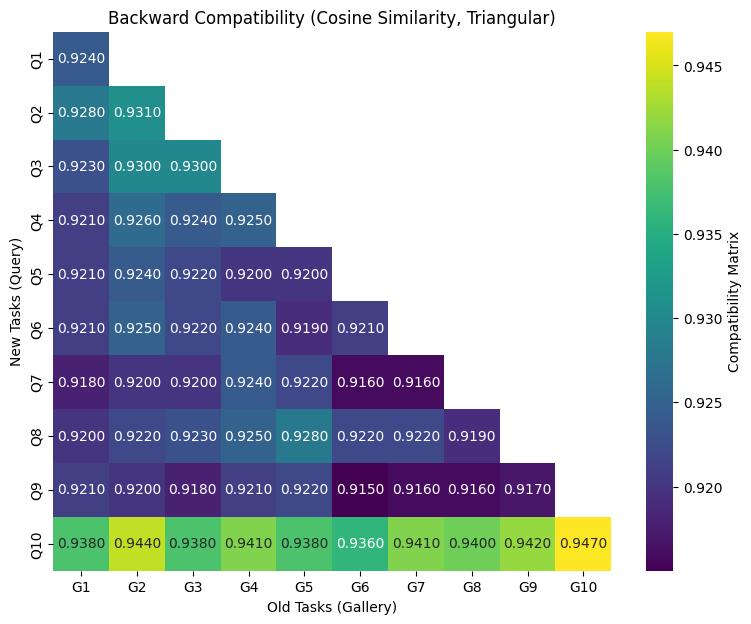

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))
mask = np.triu(np.ones_like(compatibility_matrix, dtype=bool), k=1)  # mask for upper triangle
sns.heatmap(
    compatibility_matrix,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    xticklabels=[f"G{j+1}" for j in range(NUM_TASKS)],
    yticklabels=[f"Q{i+1}" for i in range(NUM_TASKS)],
    mask=mask,
    cbar_kws={"label": "Compatibility Matrix"}
)
plt.title("Backward Compatibility (Cosine Similarity, Triangular)")
plt.xlabel("Old Tasks (Gallery)")
plt.ylabel("New Tasks (Query)")
plt.show()



## Feature Distribution Visualization via t-SNE

To analyze how feature distributions change across different model upgrade steps, t-SNE is applied to the mean-pooled and normalized features of each task.  

Each model corresponds to a specific task. Features are loaded from disk in batches, mean-pooled along the spatial or token dimension, and normalized to ensure consistency with the backward compatibility evaluation based on cosine similarity.  

For each task:
- Random sampling of features is applied if necessary to make t-SNE computation manageable.
- The resulting 2D/3D features from t-SNE are plotted in a scatter plot, with different colors representing different classes.
- The position and compactness of the clusters reveal shifts or distortions in feature distributions between different models.
- Significant shifts or overlapping clusters may indicate a reduction in compatibility with previous models, as the features no longer preserve the original spatial structure.


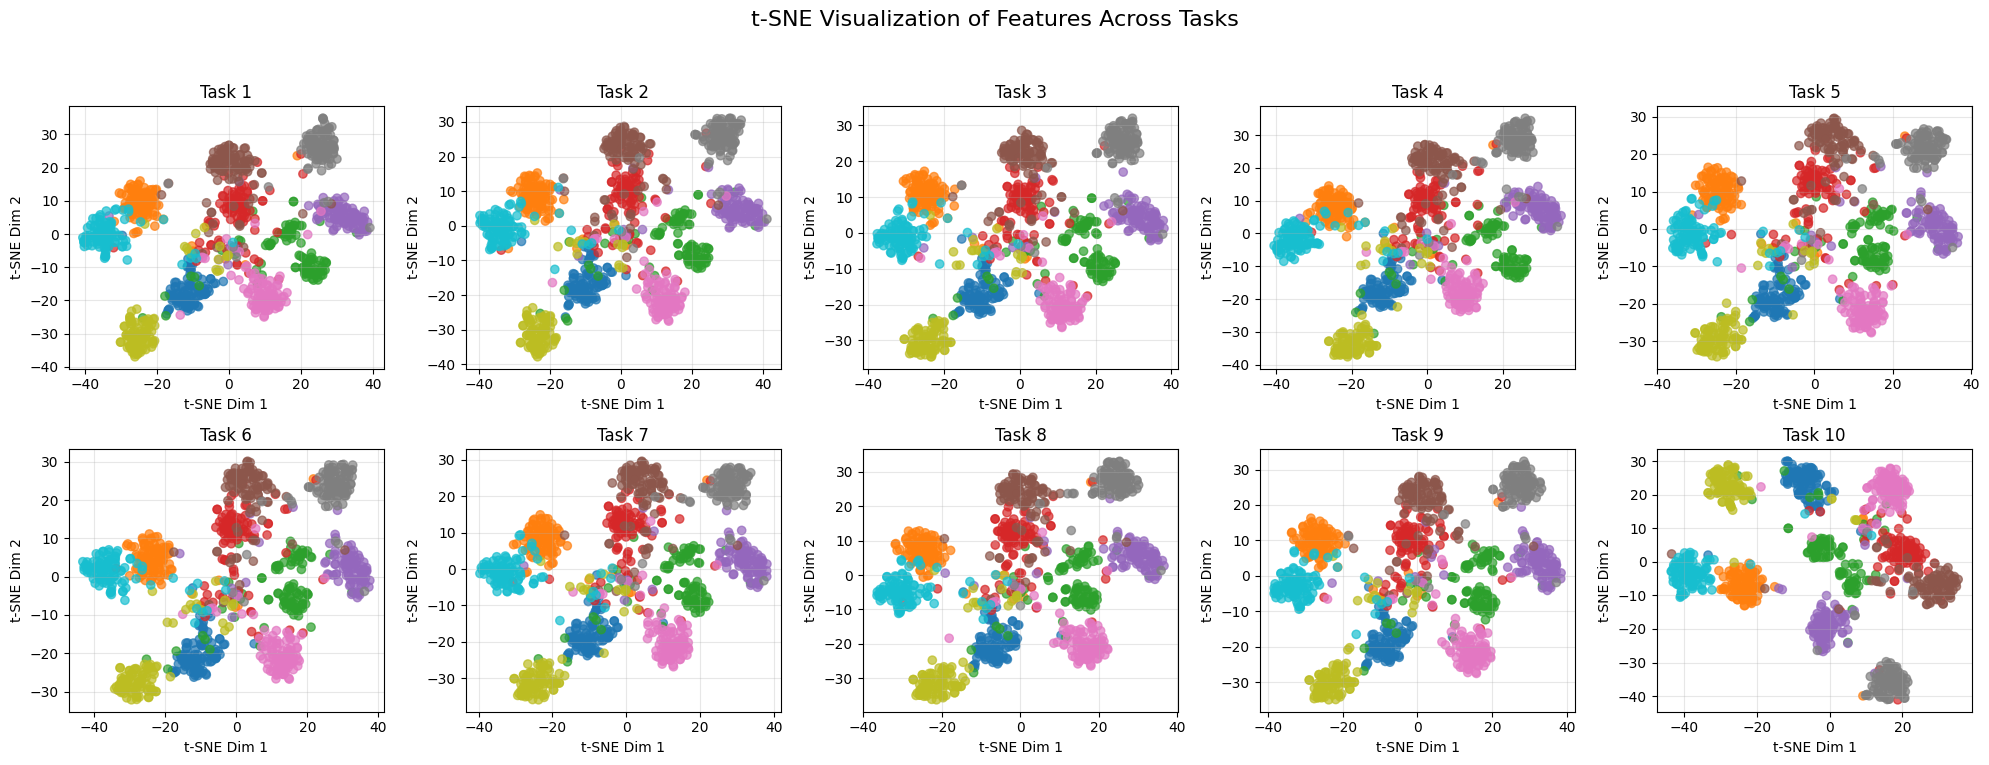

In [ ]:
# t-SNE Visualization of Feature Distributions
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random


# Plot in a grid for comparison
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for task_id in range(NUM_TASKS):
    all_features = []
    all_labels = []

    for batch_idx in range(num_batches):
        feats, labels = load_feature_batch(task_id, batch_idx)

        # Pooling: [B, 197, 768] -> [B, 768]
        feats = feats.mean(dim=1)

        # Normalize
        feats = F.normalize(feats, dim=1)

        all_features.append(feats)
        all_labels.append(labels)

    all_features = torch.cat(all_features, dim=0).cpu().numpy()
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(all_features)

    # Plotting
    ax = axes[task_id // 5, task_id % 5]
    scatter = ax.scatter(
        features_2d[:, 0],
        features_2d[:, 1],
        c=all_labels,
        cmap='tab10',
        alpha=0.7
    )
    ax.set_title(f"Task {task_id + 1}")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")
    ax.grid(True, alpha=0.3)
plt.suptitle("t-SNE Visualization of Features Across Tasks", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3D t-SNE Visualization
To gain deeper insights into the feature distributions, a 3D t-SNE visualization is performed. This allows for a more nuanced view of how features cluster in three-dimensional space, potentially revealing structures not visible in 2D projections.

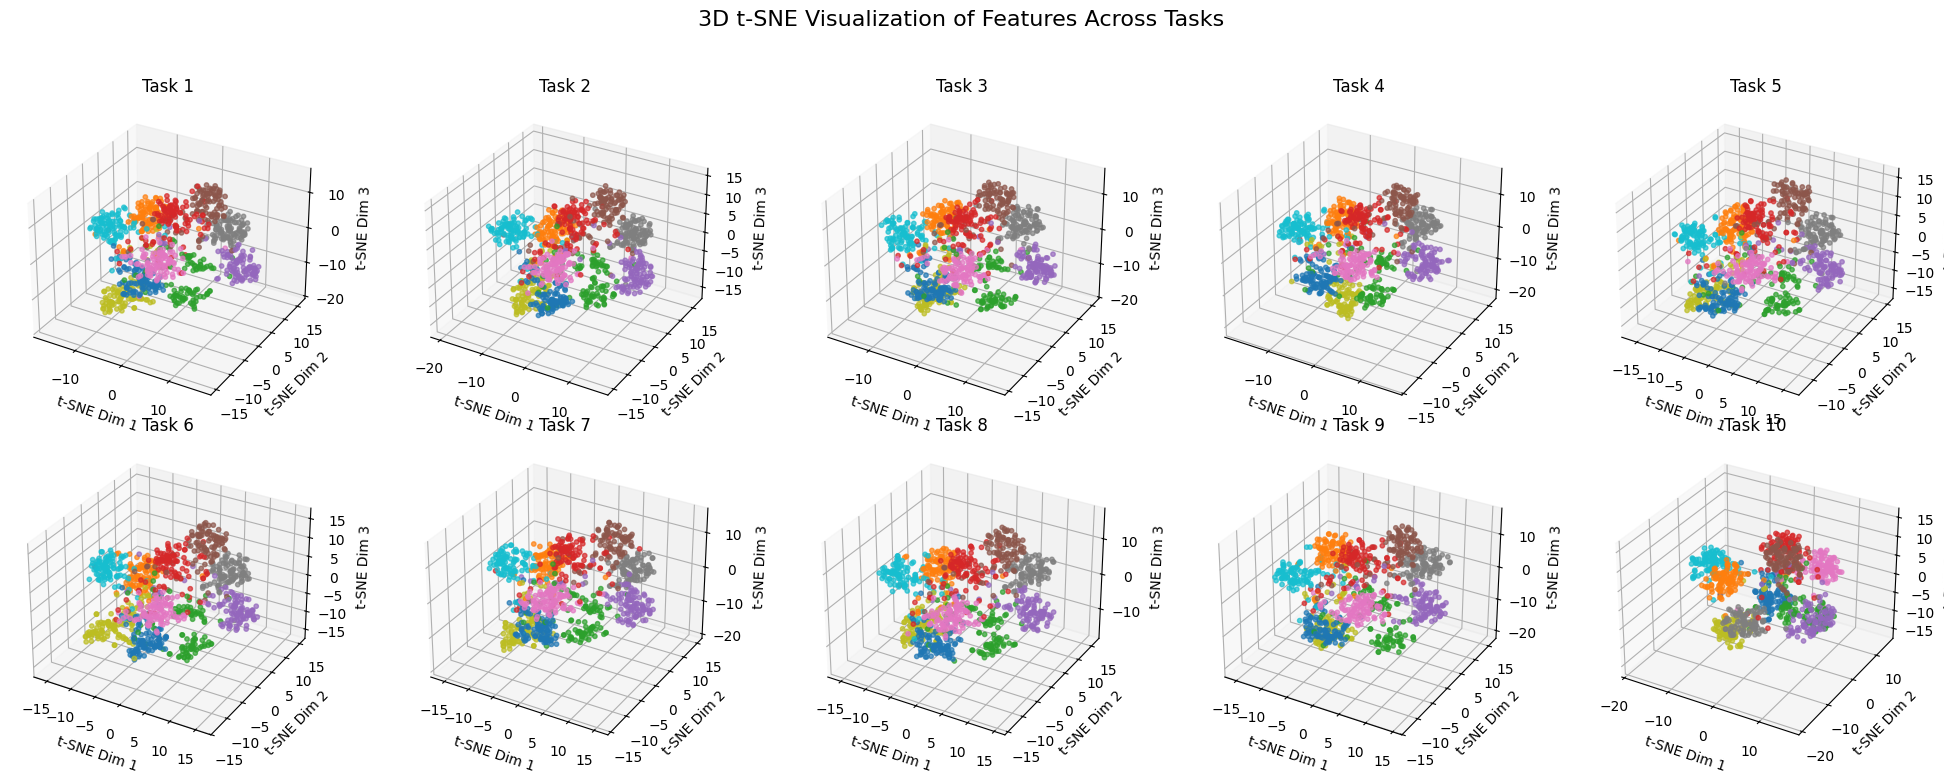

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import random

# Plot in a grid for comparison (2x5), 3D subplots
fig = plt.figure(figsize=(20, 8))
axes = []

for i in range(2 * 5):
    axes.append(fig.add_subplot(2, 5, i + 1, projection='3d'))

for task_id in range(NUM_TASKS):
    all_features = []
    all_labels = []

    for batch_idx in range(num_batches):
        feats, labels = load_feature_batch(task_id, batch_idx)

        # Pooling: [B, 197, 768] -> [B, 768]
        feats = feats.mean(dim=1)

        # Normalize
        feats = F.normalize(feats, dim=1)

        all_features.append(feats)
        all_labels.append(labels)

    all_features = torch.cat(all_features, dim=0).cpu().numpy()
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

    # t-SNE 3D
    tsne = TSNE(n_components=3, random_state=42)
    features_3d = tsne.fit_transform(all_features)

    # Plotting
    ax = axes[task_id]
    scatter = ax.scatter(
        features_3d[:, 0],
        features_3d[:, 1],
        features_3d[:, 2],
        c=all_labels,
        cmap='tab10',
        alpha=0.7,
        s=10
    )

    ax.set_title(f"Task {task_id + 1}")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")
    ax.set_zlabel("t-SNE Dim 3")


plt.suptitle("3D t-SNE Visualization of Features Across Tasks", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# Interactive version

from sklearn.manifold import TSNE
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create 2x5 3D subplot grid
fig = make_subplots(
    rows=2,
    cols=5,
    specs=[[{'type': 'scene'}] * 5,
           [{'type': 'scene'}] * 5],
    subplot_titles=[f"Task {i+1}" for i in range(NUM_TASKS)]
)

for task_id in range(NUM_TASKS):
    all_features = []
    all_labels = []

    for batch_idx in range(num_batches):
        feats, labels = load_feature_batch(task_id, batch_idx)

        # Pooling: [B, 197, 768] -> [B, 768]
        feats = feats.mean(dim=1)

        # Normalize
        feats = F.normalize(feats, dim=1)

        all_features.append(feats)
        all_labels.append(labels)

    all_features = torch.cat(all_features, dim=0).cpu().numpy()
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

    # t-SNE 3D
    tsne = TSNE(
        n_components=3,
        random_state=42,
        perplexity=30,
        learning_rate='auto'
    )
    features_3d = tsne.fit_transform(all_features)

    row = task_id // 5 + 1
    col = task_id % 5 + 1

    fig.add_trace(
        go.Scatter3d(
            x=features_3d[:, 0],
            y=features_3d[:, 1],
            z=features_3d[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color=all_labels,
                colorscale='Rainbow',
                opacity=0.7,
                colorbar=dict(title='Classes') if task_id == 0 else None
            ),
            showlegend=False
        ),
        row=row,
        col=col
    )

# Layout
fig.update_layout(
    height=800,
    width=1600,
    title_text="3D t-SNE Visualization of Features Across Tasks (Interactive)",
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()


## Single Task t-SNE Visualization
To provide a more focused analysis, t-SNE visualizations for individual tasks are generated. This allows for a detailed examination of how features cluster for a specific model checkpoint.

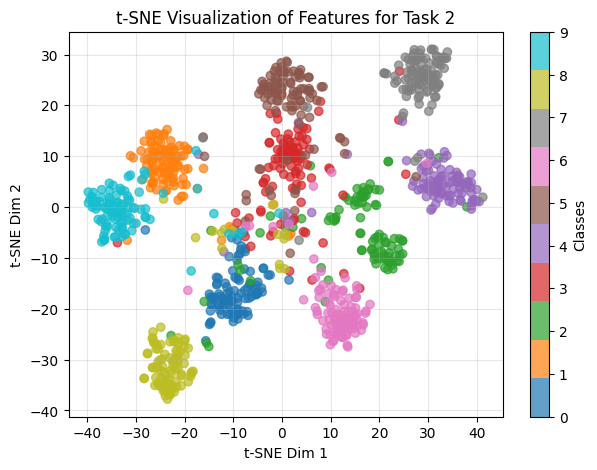

In [ ]:
# compute tsne of task 10 and plot
all_features = []
all_labels = []
task_id = 1
for batch_idx in range(num_batches):
    feats, labels = load_feature_batch(task_id, batch_idx)

    # Pooling: [B, 197, 768] -> [B, 768]
    feats = feats.mean(dim=1)

    # Normalize
    feats = F.normalize(feats, dim=1)

    all_features.append(feats)
    all_labels.append(labels)
all_features = torch.cat(all_features, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)
# Plotting
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=all_labels,
    cmap='tab10',
    alpha=0.7
)
plt.title("t-SNE Visualization of Features for Task " + str(task_id + 1) )
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, ticks=range(10), label='Classes')
plt.grid(True, alpha=0.3)
plt.show()

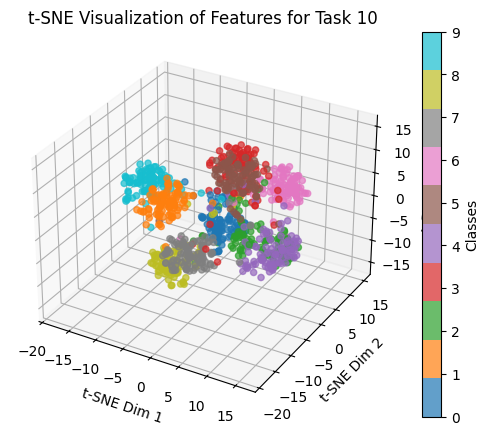

In [ ]:
# 3D t-SNE Visualization of Feature Distributions for Task id
from mpl_toolkits.mplot3d import Axes3D
all_features = []
all_labels = []
task_id = 9
for batch_idx in range(num_batches):
    feats, labels = load_feature_batch(task_id, batch_idx)
    # Pooling: [B, 197, 768] -> [B, 768]
    feats = feats.mean(dim=1)
    # Normalize
    feats = F.normalize(feats, dim=1)
    all_features.append(feats)
    all_labels.append(labels)
all_features = torch.cat(all_features, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
# t-SNE
tsne = TSNE(n_components=3, random_state=42)
features_3d = tsne.fit_transform(all_features)
# Plotting
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    features_3d[:, 0],
    features_3d[:, 1],
    features_3d[:, 2],
    c=all_labels,
    cmap='tab10',
    alpha=0.7
)
plt.title("t-SNE Visualization of Features for Task " + str(task_id + 1) )
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")
fig.colorbar(scatter, ticks=range(10), label='Classes')
plt.show()

In [ ]:
# 3D t-SNE Visualization of Feature Distributions for Task id (Interactive)

all_features = []
all_labels = []

task_id = 9

for batch_idx in range(num_batches):
    feats, labels = load_feature_batch(task_id, batch_idx)

    # Pooling: [B, 197, 768] -> [B, 768]
    feats = feats.mean(dim=1)

    # Normalize
    feats = F.normalize(feats, dim=1)

    all_features.append(feats)
    all_labels.append(labels)

all_features = torch.cat(all_features, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# t-SNE 3D
tsne = TSNE(
    n_components=3,
    random_state=42,
    perplexity=30,
    learning_rate='auto'
)
features_3d = tsne.fit_transform(all_features)

# Plotting (interactive)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=features_3d[:, 0],
            y=features_3d[:, 1],
            z=features_3d[:, 2],
            mode='markers',
            marker=dict(
                size=4,
                color=all_labels,
                colorscale='Rainbow',
                opacity=0.7,
                colorbar=dict(title='Classes')
            ),
            hovertext=[f"Class: {c}" for c in all_labels],
            hoverinfo="text"
        )
    ]
)

fig.update_layout(
    title=f"3D t-SNE Visualization of Features for Task {task_id + 1}",
    scene=dict(
        xaxis_title="t-SNE Dim 1",
        yaxis_title="t-SNE Dim 2",
        zaxis_title="t-SNE Dim 3"
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()